In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Загрузка данных
labels = np.load('data/labels.npy')
images = np.load('data/images.npy')

In [3]:
# Функция для фильтрации изображений
def denoise_image(image):
    return cv2.medianBlur(image, 3)  # Медианный фильтр

In [29]:
# Применение фильтров к изображению
def preprocess_image(image):
    # Применение фильтра GaussianBlur для уменьшения шума
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Усиление контрастности
    enhanced = cv2.convertScaleAbs(blurred, alpha=1.5, beta=0)
    # Центрирование данных: вычитание среднего
    centered = enhanced - np.mean(enhanced, axis=(0, 1), keepdims=True)
    # Нормализация
    normalized = centered / 255.0
    
    return normalized

In [30]:
def plot_images(images, preprocessed_images, num_images=10):
    plt.figure(figsize=(20, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(preprocessed_images[i])
        plt.title('Preprocessed')
        plt.axis('off')

    plt.show()

In [32]:
preprocessed_imgs = np.array([denoise_image(img) for img in images_denoised])
# Визуализация обработки изображений
plot_images(images, preprocessed_imgs, num_images=10)

NameError: name 'plot_images' is not defined

In [33]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Применение предобработки ко всем изображениям
X_train_processed = np.array([preprocess_image(img) for img in X_train])
X_test_processed = np.array([preprocess_image(img) for img in X_test])

# Кодирование меток в формат one-hot
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

In [34]:
# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(label_binarizer.classes_), activation='softmax')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Использование callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.0552 - loss: 4.1228 - val_accuracy: 0.1195 - val_loss: 3.4424 - learning_rate: 0.0010
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.1578 - loss: 3.2489 - val_accuracy: 0.3960 - val_loss: 2.4370 - learning_rate: 0.0010
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.3700 - loss: 2.4786 - val_accuracy: 0.4515 - val_loss: 2.2297 - learning_rate: 0.0010
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.4964 - loss: 2.0295 - val_accuracy: 0.6270 - val_loss: 1.7295 - learning_rate: 0.0010
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.6077 - loss: 1.7604 - val_accuracy: 0.6545 - val_loss: 1.6234 - learning_rate: 0.0010
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.6658 - loss: 1.5646 - val_accuracy: 0.6952 - val_loss: 1.5400 - learning_rate: 0.0010
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7224 - l

In [28]:
# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8581 - loss: 0.7509


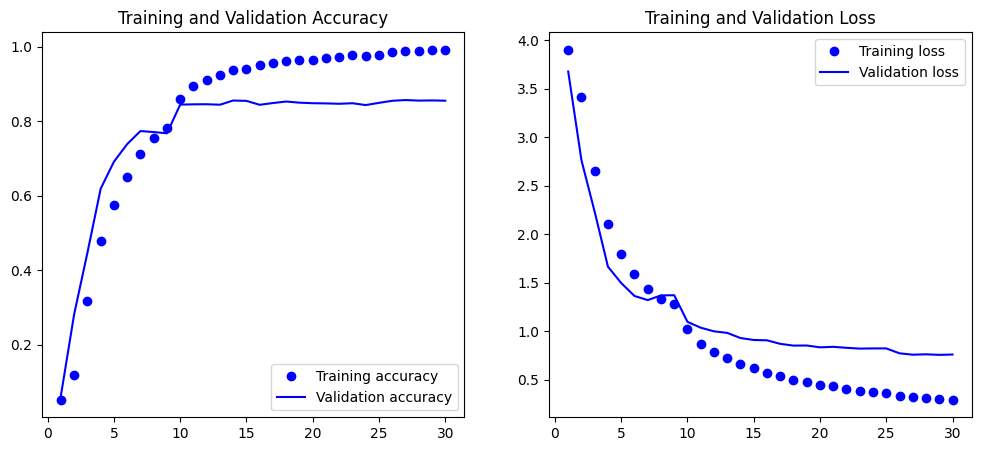

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [17]:
# Загрузка данных для предсказания
images_sub = np.load('data/images_sub.npy')

In [18]:
# Нормализация изображений
images_sub_preprocess = np.array([preprocess_image(img) for img in images_sub])
# Выполнение предсказаний
predictions = model.predict(images_sub_preprocess)
predicted_labels = label_binarizer.inverse_transform(predictions)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [19]:
# Создание DataFrame для отправки
submission = pd.DataFrame({'Id': np.arange(len(predicted_labels)), 'Category': predicted_labels})

# Проверка формата ответа
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        50000 non-null  int64
 1   Category  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


In [20]:
# Сохранение файла
submission.to_csv('data/predictions_with_filters.csv', index=False)